# <center>Lab Machine Learning 10</center>

## <center>Souaybou Bagayoko</center>
### <center> Semester 2, Nr: 303189 </center>

### Exercise 1: Recommender Dataset 

In [1]:
#import the libraries 

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import seaborn as sns 
from sklearn.preprocessing import  Normalizer
from sklearn.metrics import mean_squared_error
from  scipy.sparse import csr_matrix
from IPython.core.debugger import set_trace
from collections import Counter, defaultdict
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
#reading the data 
ratings = pd.read_csv('ml-100k/u.data', delim_whitespace=True, header=None, \
                   names=['user_id', 'item_id', 'ratings','timestamp'] )


In [3]:
user_info = pd.read_csv('ml-100k/u.user', sep='|',\
                   names=['user_id','age', 'sex', 'occupation','zipcode'])

In [4]:
data = pd.merge(ratings, user_info, on='user_id')

### some useing ploting

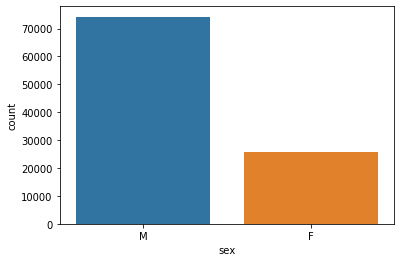

In [5]:
sns.countplot(x='sex', data=data)

###  male are more like to rate the movies than female 

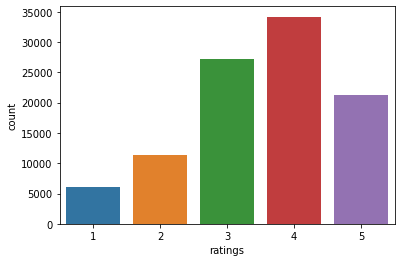

In [6]:
sns.countplot(x='ratings', data=data)

### We Notice some interesting behavior:
    the user are tend to give 4,3,5 as grating, they are more enthousiathic in grading 
 

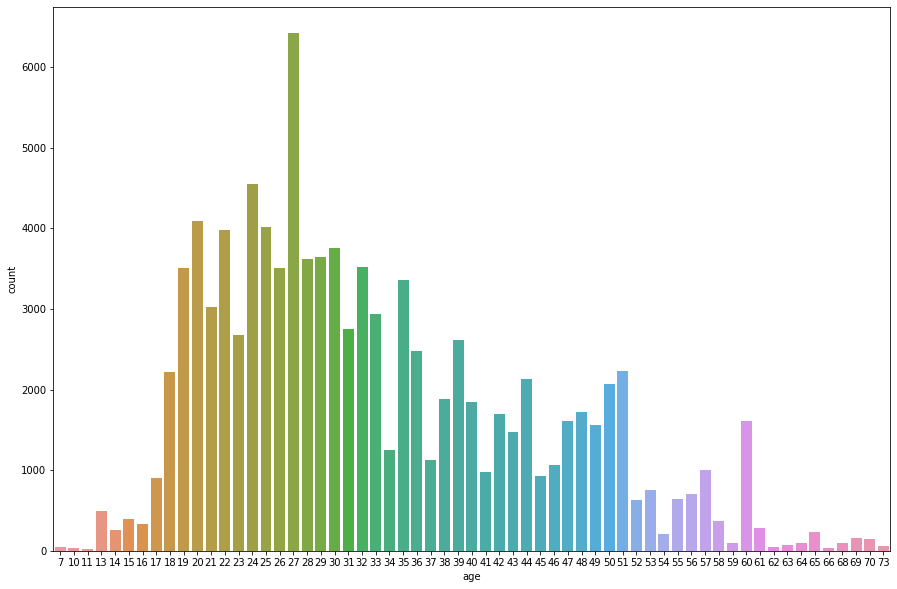

In [7]:
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x = "age", ax=ax, data=data)

### the frequency of the age show that user from 18-33 are likely to grade the movies 

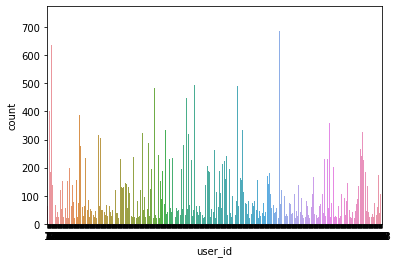

In [8]:
sns.countplot(x='user_id', data=ratings)   

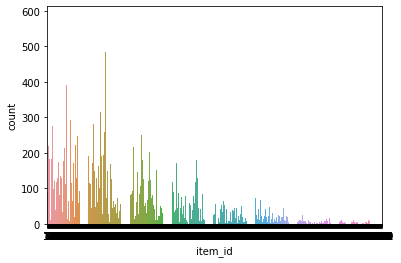

In [9]:
sns.countplot(x='item_id', data=ratings)   

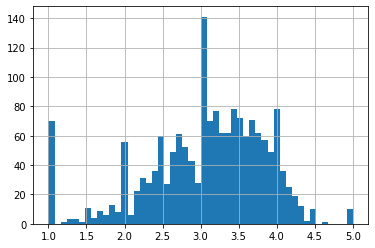

In [10]:
##soting the most popular items 
ratings.groupby('item_id')['ratings'].mean().sort_values(ascending=False).hist(bins=50)

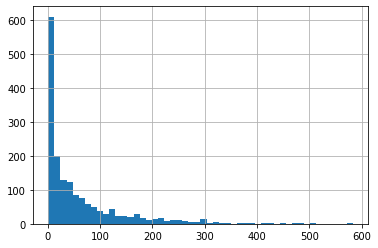

In [11]:
##soting the most count items 
ratings.groupby('item_id')['ratings'].count().sort_values(ascending=False).hist(bins=50)

## Number of unrated is much higher 

In [12]:
ratings.columns

Index(['user_id', 'item_id', 'ratings', 'timestamp'], dtype='object')

In [13]:
tidy = ratings.drop('timestamp',axis=1).pivot_table(
index=['user_id'],
columns='item_id'
)

In [14]:
tidy.fillna(value=0., inplace=True)
tidy.head()

ratings                                               ...            \
item_id    1    2    3    4    5    6    7    8    9    10    ... 1673 1674   
user_id                                                       ...             
1           5.0  3.0  4.0  3.0  3.0  5.0  4.0  1.0  5.0  3.0  ...  0.0  0.0   
2           4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  0.0  0.0   
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5           4.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

                                                 
item_id 1675 1676 1677 1678 1679 1680 1681 1682  
user_id                                          
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 1682 columns]

In [21]:
R_matrix = tidy.values
# Normalizer = StandardScaler().fit

### Normailizeing the Data  

In [22]:
from sklearn.preprocessing import StandardScaler
Normalizer = StandardScaler
Normalizer = Normalizer().fit(R_matrix)
Normalizer.transform(R_matrix)

array([[ 1.53896982,  2.19188112,  3.84109575, ..., -0.03258176,
        -0.03258176, -0.03258176],
       [ 1.0490142 , -0.38214615, -0.29969109, ..., -0.03258176,
        -0.03258176, -0.03258176],
       [-0.91080827, -0.38214615, -0.29969109, ..., -0.03258176,
        -0.03258176, -0.03258176],
       ...,
       [ 1.53896982, -0.38214615, -0.29969109, ..., -0.03258176,
        -0.03258176, -0.03258176],
       [-0.91080827, -0.38214615, -0.29969109, ..., -0.03258176,
        -0.03258176, -0.03258176],
       [-0.91080827,  3.90789929, -0.29969109, ..., -0.03258176,
        -0.03258176, -0.03258176]])

### Setting the Model: 

### Some helper functions:
<center> fm_train_test_split </center> split the ratings matrix into train and test
<center> Rating_Kfold </center> Perform cross-validation split on the given matrix 
### Note: I use different plot for the test and the train, because there are in different scale
### I pick some random ratings from the ratings matrix and replace them by zeros/not rated and create a new Rating matrix/ test where all other are zeros excepte those pick in the Original rating matrix 

In [23]:
def fm_train_test_split(Ratings, n_ratings=10):
    """
    Splite the Rating matrix into train and test 
    n_rating: the number of non_empty ranting to assign to the test 
    
    """
    test = np.zeros_like(Ratings) # the test matrix 
    xs, ys = Ratings.nonzero()    # select the non zeros coordinate in the Ratings
    index = np.arange(len(xs))
    train = Ratings.copy()
    np.random.shuffle(index)
    idx = index[:n_ratings]
    test[(xs[idx],ys[idx])] = Ratings[(xs[idx],ys[idx])]
    train[(xs[idx],ys[idx])] = 0.     
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

def Rating_Kfold(Ratings, n_fold=5):
    """
    Splite the Rating matrix into train and test 
    n_rating: the number of non_empty ranting to assign to the test 
    
    """
    xs, ys = Ratings.nonzero()    # select the non zeros coordinate in the Ratings
    index = np.arange(len(xs))   
    np.random.shuffle(index)
    batches = np.array_split(index, n_fold)
    for idx in batches:
        train = Ratings.copy()
        test = np.zeros_like(Ratings) # the test matrix 
        test[(xs[idx],ys[idx])] = Ratings[(xs[idx],ys[idx])]
        train[(xs[idx],ys[idx])] = 0.     
        assert(np.all((train * test) == 0)) 
        yield train, test



In [24]:
class SGD_MF(): 
    def __init__(self, R,test=np.array([None]), K=10, alpha=0.1, beta=0.1, \
                  verbose=True, plot=False):
        
        self.R = R
        self.test = test
        self.num_users, self.num_items = R.shape
        self.K = K
        self.lr = alpha
        self.regul = beta
        self.verbose = verbose
        self.plot = plot

    def train(self, epoch=10):
        # Initialize user and item latent feature matrice
        self.U = np.random.uniform(low=0, high=1, size=(self.num_users, self.K))
        self.V = np.random.uniform(low=0, high=1, size=(self.num_items, self.K))
        
        # Initialize the biases
        self.user_bias = np.zeros(self.num_users)
        self.item_bias = np.zeros(self.num_items)
        self.global_bias = np.mean(self.R[np.where(self.R != 0)])
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        self.training_process = []
        self.test_process     = []
        for i in range(epoch):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.rmse()
            self.training_process.append(mse)
            if self.test.any()!=None:
                test_mse = self.rmse(test=True)
                self.test_process.append(test_mse)
            if (i+1) % 10 == 0 and self.verbose:
                print(f"Iteration: {i} ;Train error = {mse}")
                if self.test.any()!=None:
                    print(f"Iteration: {i} ;test error = {test_mse}")
        if self.plot:
            self.plotting()
        return self.training_process, self.test_process
    
    def sgd(self):         

        for x,i, r in self.samples:
            prediction = self.predict(x,i)
            e = (r - prediction)
            
            # Update biases
            self.user_bias[x] +=  self.lr * (e - self.regul* self.user_bias[x])
            self.item_bias[i] +=  self.lr *(e - self.regul * self.item_bias[i])
            
            #Update latent factors
            # I copy one of the latent factor sothat both get update simultaneously
            U_copy = self.U[x,:][:]
            self.U[x, :] +=   self.lr * (e * self.V[i, :] - self.regul * self.U[x,:])
            self.V[i, :] +=   self.lr * (e * U_copy  - self.regul * self.V[i,:])
            
     
    def predict(self, u, i):
        """
        Return the prediction for a given index
        """
        predict = self.global_bias + self.user_bias[u] + self.item_bias[i]
        predict = predict + self.U[u, :].dot(self.V[i, :].T)
        return predict
    
    def full_predict(self):
        """ 
        Predict the full ratings matrix 
        """
        total_bias = self.global_bias + self.user_bias[:,np.newaxis]+ self.item_bias   
        return total_bias + self.U.dot(self.V.T)
    
    def rmse(self, test=False):
        """
        return the mean square error 
        if test: True return only for the test set
        """
        predicted = self.full_predict()
        if test:
            actual = self.test[self.test.nonzero()]
            pred = predicted[self.test.nonzero()]
            return np.sqrt(np.sum((pred - actual)**2))
        else:
            actual = self.R[self.R.nonzero()]
            pred = predicted[self.R.nonzero()] 
            return np.sqrt(np.sum((pred - actual)**2))
            
    def plotting(self):
        fig, ax = plt.subplots(1,2,figsize=(15, 5))
        fig.suptitle('Matrix Factorization', fontsize=20)
        ax[0].grid()
        ax[1].grid()
        ax[0].plot(self.training_process, label='Train',  color="r")
        if self.test.any()!= None:
            ax[1].plot(self.test_process,label='test',  color="b")
            ax[1].set_xlabel('Epochs')
            ax[1].set_ylabel('Loss')
            ax[1].legend()
        ax[0].set_title("RMSE")
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        plt.show()

Iteration: 9 ;Train error = 218.4387590817701
Iteration: 9 ;test error = 5.602856927337447
Iteration: 19 ;Train error = 176.48560940140067
Iteration: 19 ;test error = 5.718920552465882
Iteration: 29 ;Train error = 156.77386717778862
Iteration: 29 ;test error = 5.694575526358092
Iteration: 39 ;Train error = 145.20546073088371
Iteration: 39 ;test error = 5.83529534320376
Iteration: 49 ;Train error = 137.90764214544626
Iteration: 49 ;test error = 5.859685193348383
Iteration: 59 ;Train error = 132.5280107272505
Iteration: 59 ;test error = 5.888353807615822
Iteration: 69 ;Train error = 128.55357094135027
Iteration: 69 ;test error = 6.0149372729047235
Iteration: 79 ;Train error = 125.3181722372291
Iteration: 79 ;test error = 6.146510038258152
Iteration: 89 ;Train error = 122.7189750585133
Iteration: 89 ;test error = 6.282495163416306
Iteration: 99 ;Train error = 120.63710074161756
Iteration: 99 ;test error = 6.332422772160861


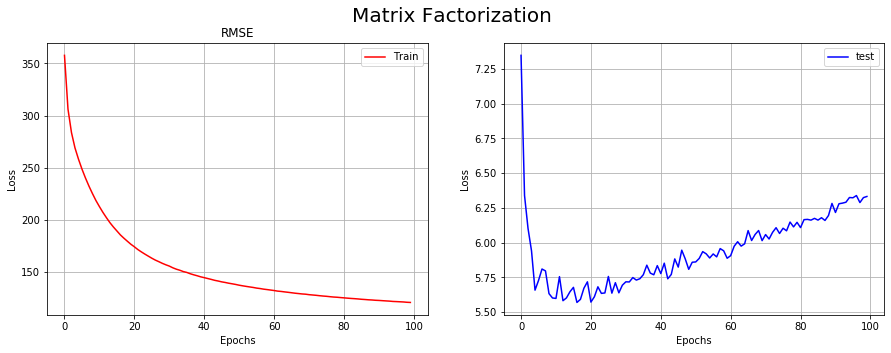

min_indece 16


In [25]:
train , test = fm_train_test_split(R_matrix, n_ratings=50)
mf = SGD_MF(train,test, K=40, alpha=0.01, beta=0.01, verbose=True, plot=True)
training_process = mf.train(epoch=100)
indeces = np.argmin(mf.test_process)
print('min_indece', indeces)

We can the best performance is withing the 10 iterations 

### evaluation and hyperparameter tuning 

In [26]:
from itertools import product
train , test = fm_train_test_split(R_matrix, n_ratings=50)

regularization = [2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-3, 1e-2,1e-1]
latent_factor  = [x for x in range(10,100,10)]
epoch = 5
best_params = {}
best_params['learning_rate'] = None
best_params['latent_factor'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None
it = 0
for regul, lr, K in product(regularization, learning_rates,latent_factor):
    MF_SGD = SGD_MF(train, test,K=K,alpha=lr,beta=regul,verbose=False)
    MF_SGD.train(epoch=epoch)
    min_idx = np.argmin(MF_SGD.test_process)
    if it>0 and MF_SGD.test_process[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = it
        best_params['learning_rate'] = lr
        best_params['latent_factor'] = K
        best_params['regularizer']   = regul
        best_params['train_mse'] = MF_SGD.training_process[min_idx]
        best_params['test_mse'] = MF_SGD.test_process[min_idx]
        best_params['model'] = MF_SGD
#         print(pd.Series(best_params))
    it +=1 

/Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in multiply
/Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in multiply
/Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in subtract
/Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in subtract
/Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in add
/Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:64: Runt

In [124]:
best_params

{'learning_rate': 0.1,
 'latent_factor': 20,
 'n_iter': 19,
 'train_mse': 325.5187405536677,
 'test_mse': 6.569277461380019,
 'model': <__main__.SGD_MF at 0x1a2a92eb00>,
 'regularizer': 2}

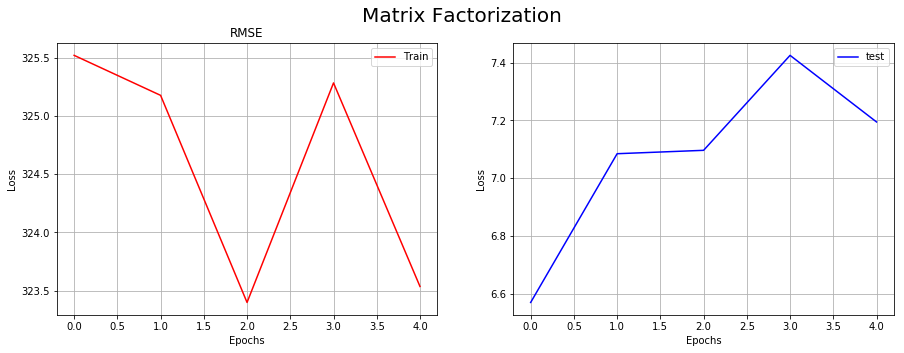

In [125]:
best_params['model'].plotting()

### Exercise 3 : 
In this Part I will use Sklearn 

In [147]:
from itertools import product
from sklearn.decomposition import NMF

def get_rmse(predict, actual):
    real = actual[actual.nonzero()]
    pred = predict[actual.nonzero()] 
    return np.sqrt(np.sum((pred - real)**2))

#### defining the model ##############
model = NMF(init='random', solver='cd')

#######defining the Hyperparameters######
regularization =[1e-5,1e-4,1e-3, 1e-2]
latent_factor  = [x for x in range(10,100,10)]
iteration  = [x for x in range(1,10,2)]
best_params = {}
best_params['latent_factor'] = None
best_params['n_iter'] = 0
best_params['test_mse'] = np.inf
best_params['model'] = None

Kfold = 3
###### cross validation ##### 
global_loss = []
it = 0
for train , test in Rating_Kfold(R_matrix, n_fold=Kfold):
    print(f"fold number {it+1}")
 
    loss_his = []
    for regul, max_iter, K in product(regularization, iteration,latent_factor):
        model_param = {'n_components':K, 'max_iter':max_iter, 'alpha':regul}
        model.set_params(**model_param)
        H = model.fit_transform(train)
        W = model.components_
        predict = H.dot(W)
        test_rmse = get_rmse(predict, test)
        loss_his.append(test_rmse)  
        
    idx = np.argmin(loss_his)    
    global_loss.append(loss_his)
    if  loss_his[idx] < best_params['test_mse']:
        best_params['n_iter'] = it
        best_params['latent_factor'] = K
        best_params['regularizer']   = regul
        best_params['test_mse'] = loss_his[idx]
        best_params['model'] = model
    it +=1 


fold number 1
fold number 2
fold number 3
fold number 4
fold number 5
fold number 6
fold number 7
fold number 8
fold number 9
fold number 10
fold number 11
fold number 12
fold number 13
fold number 14
fold number 15
fold number 16
fold number 17
fold number 18
fold number 19
fold number 20
fold number 21
fold number 22
fold number 23
fold number 24
fold number 25
fold number 26
fold number 27
fold number 28
fold number 29
fold number 30
fold number 31
fold number 32
fold number 33
fold number 34
fold number 35
fold number 36
fold number 37
fold number 38
fold number 39
fold number 40
fold number 41
fold number 42
fold number 43
fold number 44
fold number 45
fold number 46
fold number 47
fold number 48
fold number 49
fold number 50
fold number 51
fold number 52
fold number 53
fold number 54
fold number 55
fold number 56
fold number 57
fold number 58
fold number 59
fold number 60
fold number 61
fold number 62
fold number 63
fold number 64
fold number 65
fold number 66
fold number 67
fold

KeyboardInterrupt: 

***show the best model
comparing with the model in task 1 is not done due the time it take to runs 
I have not use for my model 3kfold 
best_params***

In [148]:
best_params

{'latent_factor': 90,
 'n_iter': 48,
 'test_mse': 0.0697288351832086,
 'model': NMF(alpha=0.01, beta_loss='frobenius', init='random', l1_ratio=0.0,
   max_iter=7, n_components=70, random_state=None, shuffle=False,
   solver='cd', tol=0.0001, verbose=0),
 'regularizer': 0.01}

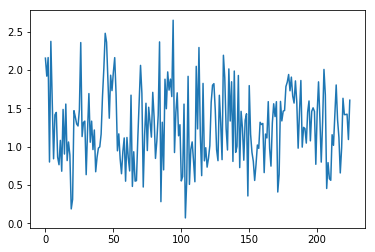

In [149]:
plt.plot(global_loss[48
                    ])

In [ ]:
## the Rining is taking too long 

### Result:
#### In the above model: 
#### solver : Coordinate Descent
#### H , W are the latent Factors 
#### n_components: the latent number 
#### alpha:         The gularization parameter 
#### frobenius norm: A generaliztion of L2 norm for the latent factors